In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint,LSODA,solve_ivp
%load_ext autoreload
%autoreload 2

from src.functions import *
from src.params import *
from omegaconf import OmegaConf

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#from src.solve_ode import *
#from src.solve_interactive import *

Specify model to be tested

In [17]:
model_number=0

H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]
# loading
name='src\conf\params\machine'+str(model_number+1)+'.yaml'
config = OmegaConf.load(name)
config

{'D': 2.364, 'E_fd': 1.08, 'H': 23.64, 'P_m': 0.71, 'Rs': 0, 'T_d_dash': 8.96, 'T_q_dash': 0.31, 'X_d_dash': 0.0608, 'X_q_dash': 0.0969, 'Xd': 0.146, 'Xq': 0.0969}

Specify initial conditions

In [18]:
model_number=3

H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]

delta0=0.38463 #0.3
omega0=0.15152 #0.3
E_d_dash0=1
E_q_dash0=0.56887 #1
omega_s0=0
omega_B0=2*np.pi*50
theta_vs0=0
V0=1 
Vs0=1 

K_A0=20
T_A0=0.2
K_E0=1.0
T_E0=0.314
K_F0=0.063
T_F0=0.35
V_ref0=1.095

R_F0 = 1
V_r0 = 0.05
e_f0=1
u0=1
P_m0 = 0.1
E_fd0 = 0

P_c0 = 0.7
R_d0 = 0.05
T_ch0 = 0.4 # p 86
T_sv0 = 0.2
P_sv0 = 0.1




0.2995 0.646 0.1 5.148 314.1592653589793 2.0 0.15152 0.38463 1 0.56887


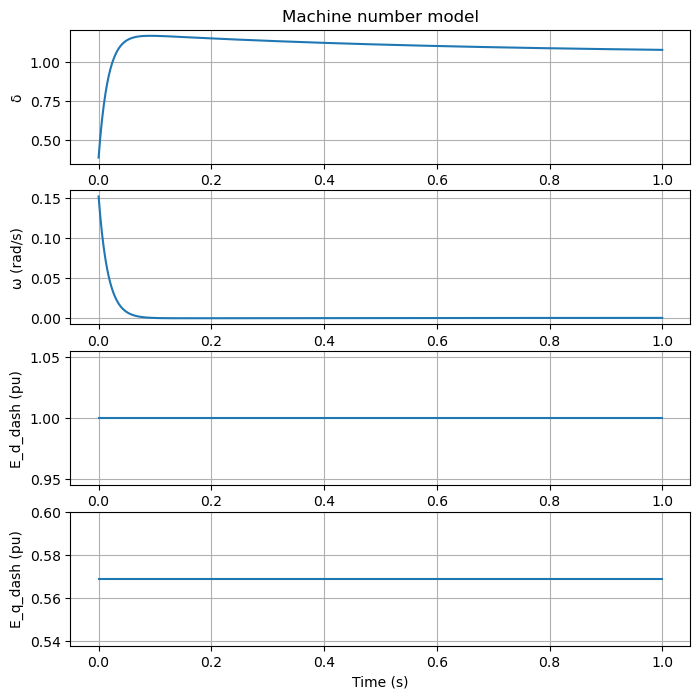

In [19]:
class ODE_solver_system():
    def __init__(self, param_sim, ini_cond, t_final, num_points):
        self.damping    = np.array(param_sim[0], dtype=np.longdouble)
        self.freq       = np.array(param_sim[1], dtype=np.longdouble)
        self.H          = np.array(param_sim[2], dtype=np.longdouble)
        self.P_gen      = np.array(param_sim[3], dtype=np.longdouble)
        self.Xd_prime   = np.array(param_sim[4], dtype=np.longdouble)
        self.Xq_prime   = np.array(param_sim[5], dtype=np.longdouble)
        self.t_final    = t_final
        self.num_points = num_points + 1
        self.delta      = np.array(ini_cond[0], dtype=np.longdouble)
        self.omega      = np.array(ini_cond[1], dtype=np.longdouble)
        self.ed_prime   = np.array(ini_cond[2], dtype=np.longdouble)
        self.eq_prime   = np.array(ini_cond[3], dtype=np.longdouble)
        
 
    def system_diff_eq(self, t, Y):
        u, v, Ed, Eq = Y
        Id =  1/self.Xd_prime *(Eq-1*np.cos(u))
        Iq = -1/self.Xq_prime *(Ed-1*np.sin(u))
        d_delta =  v * self.freq
        d_omega = (self.P_gen - Ed * Id - Eq*Iq - (self.Xq_prime-self.Xd_prime)* Id*Iq - self.damping * v* self.freq)/(2*self.H)
        dEd = 0
        dEq = 0

        return [d_delta, d_omega, dEd, dEq]
   
    def solve_system(self):
        t_span, t_eval = set_time(self.t_final, self.num_points)
        solution = solve_ivp(self.system_diff_eq, t_span, [self.delta, self.omega, self.ed_prime, self.eq_prime],t_eval=t_eval)
        return solution
    
param_sim = [D0, omega_B0, H0, P_m, X_d_dash0, X_q_dash0]
print(X_d_dash0, X_q_dash0, P_m0, H0, omega_B0, D0, omega0, delta0, E_d_dash0, E_q_dash0)
ini_cond = [delta0, omega0, E_d_dash0, E_q_dash0]
t_final = 1
num_points = 1000
ode_solver = ODE_solver_system(param_sim, ini_cond, t_final, num_points)
solution= ode_solver.solve_system()
plotting_solution_gridspec_original(solution,"model")



In [20]:
def calculate_currents( theta, E_d_dash, E_q_dash, X_q_dash, X_d_dash, Vs, theta_vs):
    
    """
    Calculates the currents I_d and I_q based on the given parameters.

    Parameters:
    theta (rad): The angle .
    E_d_dash (pu): The value of E_d_dash.
    E_q_dash (pu): The value of E_q_dash.

    Returns:
    tuple: A tuple containing the calculated values of I_d and I_q.
    """

    Rs=0.0
    Re=0.0
    Xep=0.0
    
    alpha = [[(Rs+Re), -(X_q_dash+Xep)], [(X_d_dash+Xep), (Rs+Re)]]
    beta = [[E_d_dash - Vs*np.sin(theta-theta_vs)], [E_q_dash - Vs*np.cos(theta-theta_vs)]]
    inv_alpha = np.linalg.inv(alpha)
    # Calculate I_d and I_q
    I_d= inv_alpha[0][0]*beta[0][0] + inv_alpha[0][1]*beta[1][0]
    I_q= inv_alpha[1][0]*beta[0][0] + inv_alpha[1][1]*beta[1][0]

    #I_t = np.matmul(inv_alpha, beta)
    #I_d = I_t[0][0]
    #I_q = I_t[1][0]
    return I_d, I_q


def calculate_voltages(theta, I_d, I_q, Vs , theta_vs):
    """
    Calculate the voltage V_t based on the given inputs, for AVR model

    Parameters:
    theta (rad): The angle in radians.
    I_d (pu): The d-axis current.
    I_q (pu): The q-axis current.

    Returns:
    float: The magnitude of the total voltage V_t(pu).
    """
    Re = 0.0
    Xep = 0.0
    V_d = Re * I_d - Xep * I_q + Vs * np.sin(theta - theta_vs)
    V_q = Re * I_q + Xep * I_d + Vs * np.cos(theta - theta_vs)
    V_t = np.sqrt(V_d ** 2 + V_q ** 2)  # equal to Vs
    return V_t

def synchronous_machine_equations(t, x, model_flag, omega_B, H, P_m, X_q_dash, X_d_dash, D, T_d_dash, X_d, E_fd, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs):
    """
    Calculates the derivatives of the state variables for the synchronous machine model.

    Parameters:
        t (float): The current time.
        x (list): A list of state variables, different for each model type.

    Returns:
        list: A list of derivatives, different for each model type.
    """
    if model_flag=="SM_IB" or model_flag=="SM":
        theta, omega, E_d_dash, E_q_dash = x
    if model_flag=="SM_AVR":
        theta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd = x
    if model_flag=="SM_AVR_GOV":
        theta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv = x

    
    # Calculate currents from algebraic equations
    I_d, I_q = calculate_currents( theta, E_d_dash, E_q_dash, X_q_dash, X_d_dash, Vs, theta_vs)

    if (model_flag=="SM_AVR" or model_flag=="SM_AVR_GOV"): # calculate V_t from algebraic equations
        V_t = calculate_voltages(theta, I_d, I_q, Vs , theta_vs)
    
    # Calculate theta derivative
    dtheta_dt = omega
    
    # Calculate omega derivative
    if model_flag=="SM_AVR_GOV": # calculate omega derivative from algebraic equations
        domega_dt = (omega_B / (2 * H)) * (P_m - E_d_dash * I_d - E_q_dash * I_q - (X_q_dash - X_d_dash) * I_q * I_d - D * omega)
    else:
        domega_dt = (omega_B / (2 * H)) * (P_m - E_d_dash * I_d - E_q_dash * I_q - (X_q_dash - X_d_dash) * I_q * I_d - D * omega)
    
    # Calculate E_dash derivatives
    if model_flag=="SM_IB":
        dE_q_dash_dt = 0
        dE_d_dash_dt = 0
        return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt]
    
    if model_flag=="SM":
        dE_q_dash_dt = (1 / T_d_dash) * (- E_q_dash - I_d * (X_d - X_d_dash) + E_fd)
        dE_d_dash_dt = (1 / T_q_dash) * (- E_d_dash + I_q * (X_q - X_q_dash))
        return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt]

    
    # Automatic Voltage Regulator (AVR) dynamics 4.46-4.48
    # Exciter and AVR equations
    if (model_flag=="SM_AVR" or model_flag=="SM_AVR_GOV"):
        dE_q_dash_dt = (1 / T_d_dash) * (- E_q_dash - I_d * (X_d - X_d_dash) + E_fd)
        dE_d_dash_dt = (1 / T_q_dash) * (- E_d_dash + I_q * (X_q - X_q_dash))
        dR_F_dt      = (1 / T_F) * (-R_F + (K_F / T_F) * E_fd)
        dV_r_dt      = (1 / T_A) * (-V_r + (K_A * R_F) - (K_A * K_F / T_F) * E_fd + K_A * (V_ref - V_t))
        dE_fd_dt     = (1 / T_E) * (-(K_E + 0.098 * np.e**(E_fd*0.55)) * E_fd + V_r)
        
        if model_flag=="SM_AVR_GOV":        # Governor equations # recheck it after the meeting
            dP_m_dt  = (1 / T_ch) * (-P_m  + P_sv) # 4.110  from dynamics dT_m
            dP_sv_dt = (1 / T_sv) * (-P_sv + P_c - (1/R_d) * (omega/omega_B))
            return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt, dR_F_dt, dV_r_dt, dE_fd_dt, dP_m_dt, dP_sv_dt]
    else:
        return "No such model implemented."



def synchronous_machine_equations_SM_IB1(t, x, omega_B, H, P_m, X_q_dash, X_d_dash, D, Vs, theta_vs):
    theta, omega, E_d_dash, E_q_dash = x
    I_d, I_q = calculate_currents(theta, E_d_dash, E_q_dash, X_q_dash, X_d_dash, Vs, theta_vs)
    """
    Vs = 1
    theta_vs = 0
    P_e = (E_q_dash * V / X_d_dash) * np.sin(theta - theta_vs)

    # Calculate acceleration
    ddelta_dt = (omega-omega_s0) * omega_B
    domega_dt = (omega_B / (2 * H)) * (P_m - P_e - D * (omega-omega_s0))
    """
    dtheta_dt = omega * omega_B
    domega_dt = (1 / (2 * H)) * (P_m - E_d_dash * I_d - E_q_dash * I_q - (X_q_dash - X_d_dash) * I_q * I_d - D * omega * omega_B)
    
    dE_q_dash_dt = 0
    dE_d_dash_dt = 0
    return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt]
"""
        Id =  1/self.Xd_prime *(Eq-1*np.cos(u))
        Iq = -1/self.Xq_prime *(Ed-1*np.sin(u))
        d_delta =  v * self.freq
        d_omega = (self.P_gen - Ed * Id - Eq*Iq - (self.Xq_prime-self.Xd_prime)* Id*Iq - self.damping * v)/(2*self.H)
"""

def synchronous_machine_equations_SM(t, x, omega_B, H, P_m, X_q_dash, X_d_dash, D, T_d_dash, X_d, E_fd, T_q_dash, X_q, Vs, theta_vs):
    theta, omega, E_d_dash, E_q_dash = x
    I_d, I_q = calculate_currents(theta, E_d_dash, E_q_dash, X_q_dash, X_d_dash, Vs, theta_vs)
    dtheta_dt = omega 
    domega_dt = ( omega_B / (2 * H)) * (P_m - E_d_dash * I_d - E_q_dash * I_q - (X_q_dash - X_d_dash) * I_q * I_d - D * omega )
    dE_q_dash_dt = (1 / T_d_dash) * (- E_q_dash - I_d * (X_d - X_d_dash) + E_fd)
    dE_d_dash_dt = (1 / T_q_dash) * (- E_d_dash + I_q * (X_q - X_q_dash))
    return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt]

def synchronous_machine_equations_SM_AVR(t, x, omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, Vs, theta_vs):
    theta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd = x
    I_d, I_q = calculate_currents(theta, E_d_dash, E_q_dash, X_q_dash, X_d_dash, Vs, theta_vs)
    V_t = calculate_voltages(theta, I_d, I_q, Vs , theta_vs)
    dtheta_dt = omega
    domega_dt = (omega_B / (2 * H)) * (P_m - E_d_dash * I_d - E_q_dash * I_q - (X_q_dash - X_d_dash) * I_q * I_d - D * omega )
    dE_q_dash_dt = (1 / T_d_dash) * (- E_q_dash - I_d * (X_d - X_d_dash) + E_fd)
    dE_d_dash_dt = (1 / T_q_dash) * (- E_d_dash + I_q * (X_q - X_q_dash))
    dR_F_dt = (1 / T_F) * (-R_F + (K_F / T_F) * E_fd)
    dV_r_dt = (1 / T_A) * (-V_r + (K_A * R_F) - (K_A * K_F / T_F) * E_fd + K_A * (V_ref - V_t))
    dE_fd_dt = (1 / T_E) * (-(K_E + 0.098 * np.e**(E_fd*0.55)) * E_fd + V_r)
    return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt, dR_F_dt, dV_r_dt, dE_fd_dt]

def synchronous_machine_equations_SM_AVR_GOV(t, x, omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs):
    theta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv = x
    I_d, I_q = calculate_currents(theta, E_d_dash, E_q_dash, X_q_dash, X_d_dash,Vs, theta_vs)
    V_t = calculate_voltages(theta, I_d, I_q, Vs , theta_vs)
    dtheta_dt = omega
    domega_dt = (omega_B / (2 * H)) * (P_m - E_d_dash * I_d - E_q_dash * I_q - (X_q_dash - X_d_dash) * I_q * I_d - D * omega )
    dE_q_dash_dt = (1 / T_d_dash) * (- E_q_dash - I_d * (X_d - X_d_dash) + E_fd)
    dE_d_dash_dt = (1 / T_q_dash) * (- E_d_dash + I_q * (X_q - X_q_dash))
    dR_F_dt = (1 / T_F) * (-R_F + (K_F / T_F) * E_fd)
    dV_r_dt = (1 / T_A) * (-V_r + (K_A * R_F) - (K_A * K_F / T_F) * E_fd + K_A * (V_ref - V_t))
    dE_fd_dt = (1 / T_E) * (-(K_E + 0.098 * np.e**(E_fd*0.55)) * E_fd + V_r)
    dP_m_dt = (1 / T_ch) * (-P_m + P_sv)
    dP_sv_dt = (1 / T_sv) * (-P_sv + P_c - (1/R_d) * (omega/omega_B))
    return [dtheta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt, dR_F_dt, dV_r_dt, dE_fd_dt, dP_m_dt, dP_sv_dt]

[0.38463, 0.15152, 1, 0.56887, 1, 0.05, 0]


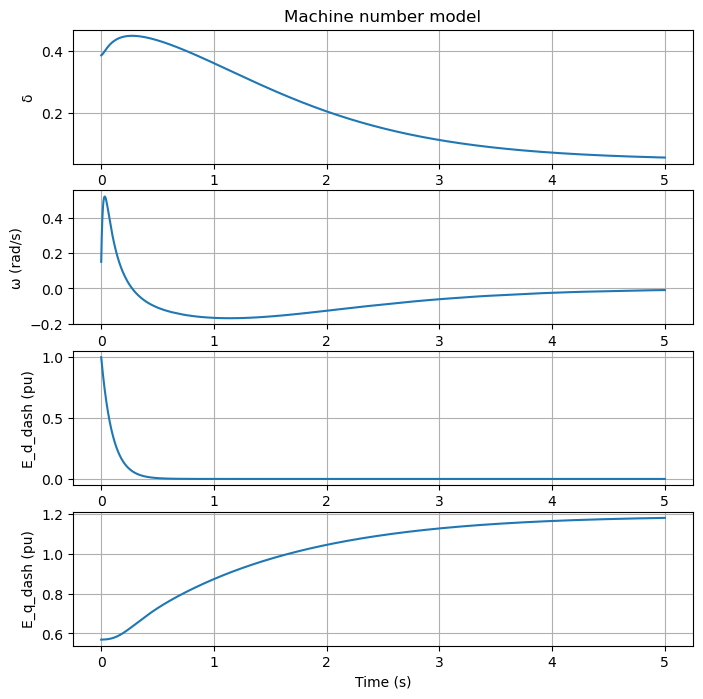

In [21]:
# synchronous_machine_equations(t, x, model_flag, omega_B, H, P_m, X_q_dash, X_d_dash, D, T_d_dash, X_d, E_fd, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs):
def plot_synchronous_machine(modelling, time_h, delta, omega,  E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv, omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs):
    t_span, t_eval = set_time(time_h,1000) # Time span and points to evaluate the solution
    modelling=modelling
    # Initial state
    if modelling=="SM_IB":
        y0 = [delta, omega, E_d_dash, E_q_dash]                        
        solution = solve_ivp(synchronous_machine_equations_SM_IB1, t_span, y0, args=(omega_B, H, P_m, X_q_dash, X_d_dash, D, Vs, theta_vs), t_eval=t_eval)
    if modelling=="SM":
        y0 = [delta, omega, E_d_dash, E_q_dash]
        solution = solve_ivp(synchronous_machine_equations_SM, t_span, y0, args=(omega_B, H, P_m, X_q_dash, X_d_dash, D, T_d_dash, X_d, E_fd, T_q_dash, X_q, Vs, theta_vs), t_eval=t_eval)
    if modelling=="SM_AVR":
        y0 = [delta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd]
        print(y0)
        solution = solve_ivp(synchronous_machine_equations_SM_AVR, t_span, y0, args=(omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, Vs, theta_vs), t_eval=t_eval)
    if modelling=="SM_AVR_GOV":
        y0 = [delta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv]
        solution = solve_ivp(synchronous_machine_equations_SM_AVR_GOV, t_span, y0, args=(omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs), t_eval=t_eval)        
    
    plotting_solution_gridspec_original(solution,"model",False)
    return 
# Plot directly for the preselected initial conditions
modelling = "SM_AVR"
time_h = 5
plot_synchronous_machine(modelling, time_h , delta0, omega0,  E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0, omega_B0, H0, X_q_dash0, X_d_dash0, D0, T_d_dash0, X_d0, T_q_dash0, X_q0, T_F0, K_F0, T_A0, K_A0, V_ref0, T_E0, K_E0, T_ch0, T_sv0, P_c0, R_d0, Vs0, theta_vs0)

In [22]:

# 2 axis model
 
 #H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]

# Define the parameters and their properties in a dictionary

delta_init = 0.38463
omega_init  = -6.85
E_d_dash_init = 0
E_q_dash_init = 1

param_properties = {
    'time_h': {'min': 0.1, 'max': 100, 'step': 0.1, 'default': 10},
    'delta': {'min': 0, 'max': 2*np.pi, 'step': 0.01, 'default': delta_init},
    'omega': {'min': -100, 'max': 100, 'step': 0.01, 'default': omega_init},
    'E_d_dash': {'min': 0, 'max': 3, 'step': 0.01, 'default': E_d_dash_init},
    'E_q_dash': {'min': 0, 'max': 3, 'step': 0.01, 'default': E_q_dash_init},
    'E_fd': {'min': 0, 'max': 2, 'step': 0.01, 'default': E_fd0},
    'P_m': {'min': -2, 'max': 5, 'step': 0.001, 'default': P_m0},
    'theta_vs': {'min': 0, 'max': 2*np.pi, 'step': 0.1, 'default': theta_vs0},
    'Vs': {'min': 0, 'max': 2.5, 'step': 0.1, 'default': V0},
    'T_d_dash': {'min': 0.01, 'max': 10, 'step': 0.0001, 'default': T_d_dash0},
    'T_q_dash': {'min': 0.01, 'max': 10, 'step': 0.0001, 'default': T_q_dash0},
    'X_d': {'min': 0, 'max': 2, 'step': 0.0001, 'default': X_d0},
    'X_d_dash': {'min': 0.001, 'max': 1, 'step': 0.0001, 'default': X_d_dash0},
    'X_q': {'min': 0, 'max': 2, 'step': 0.0001, 'default': X_q0},
    'X_q_dash': {'min': 0.001, 'max': 1, 'step': 0.0001, 'default': X_q_dash0},
    'H': {'min': 0, 'max': 40, 'step': 0.01, 'default': H0},
    'D': {'min': 0, 'max': 5, 'step': 0.0001, 'default': D0},
    'R_F': {'min': 0, 'max': 1, 'step': 0.001, 'default': R_F0},
    'V_r': {'min': 0, 'max': 1, 'step': 0.001, 'default': V_r0},
}

parameters = {
    'omega_B': 2*np.pi*50,
    'K_A': 20,
    'T_A': 0.2,
    'K_E': 1.0,
    'T_E': 0.314,
    'K_F': 0.063,
    'T_F': 0.35,
    'V_ref': 1.095,
    'P_m': 0.1,
    'E_fd': 0,
    'P_c': 0.7,
    'R_d': 0.05,
    'T_ch': 0.2,  # p 86
    'T_sv': 0.4,
    'P_sv': 0.1,
}


def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

def plot_synchronous_machine_interactive(modelling_flag, param_properties, parameters):
    # Create widgets dynamically based on flags
    widget_params = {}
    for param, properties in param_properties.items():
        widget_params[param] = widgets.FloatSlider(
                min=properties['min'],
                max=properties['max'],
                step=0.0001,
                value=properties['default'],
                layout=widgets.Layout(width='50%')
        )
    for param, value in parameters.items():
        #keep them disabled for now
        widget_params[param] = widgets.FloatSlider(
                min=0,
                max=500,
                step=0.0001,
                value=value,
                disabled=False,
                layout=widgets.Layout(width='50%')
        )
    # create widget for model selection as dropdown
    widget_params['modelling'] = widgets.Dropdown(
        options=modelling_flag,
        value=modelling_flag[0],
        description='Model:',
        disabled=False,
        layout=widgets.Layout(width='50%')
    )

    controls = widgets.VBox([widget_params[param] for param in widget_params.keys()])
    controls.layout = make_box_layout()

    #add also the modelling flag
    output = widgets.Output()
    outbox = widgets.Box([output])
    interact(plot_synchronous_machine, **widget_params)
    output.layout = make_box_layout()
    
    


modelling_flag = ['SM_IB','SM','SM_AVR','SM_AVR_GOV']
plot_synchronous_machine_interactive(modelling_flag, param_properties,parameters)


interactive(children=(Dropdown(description='Model:', layout=Layout(width='50%'), options=('SM_IB', 'SM', 'SM_A…

In [23]:
# Define plot_synchronous_machine function
def plot_synchronous_machine(modelling, time_h, delta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv, omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs):
    t_span = (0, time_h)  # Define time span
    t_eval = np.linspace(*t_span, 1000)  # Define points to evaluate the solution
    
    # Initial state and solution based on the model flag
    if modelling == "SM_IB":
        y0 = [delta, omega, E_d_dash, E_q_dash]
        solution = solve_ivp(synchronous_machine_equations_SM_IB1, t_span, y0, args=(omega_B, H, P_m, X_q_dash, X_d_dash, D, Vs, theta_vs), t_eval=t_eval)
    elif modelling == "SM":
        y0 = [delta, omega, E_d_dash, E_q_dash]
        solution = solve_ivp(synchronous_machine_equations_SM, t_span, y0, args=(omega_B, H, P_m, X_q_dash, X_d_dash, D, T_d_dash, X_d, E_fd, T_q_dash, X_q, Vs, theta_vs), t_eval=t_eval)
    elif modelling == "SM_AVR":
        y0 = [delta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd]
        solution = solve_ivp(synchronous_machine_equations_SM_AVR, t_span, y0, args=(omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, Vs, theta_vs), t_eval=t_eval)
    elif modelling == "SM_AVR_GOV":
        y0 = [delta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv]
        solution = solve_ivp(synchronous_machine_equations_SM_AVR_GOV, t_span, y0, args=(omega_B, H, X_q_dash, X_d_dash, D, T_d_dash, X_d, T_q_dash, X_q, T_F, K_F, T_A, K_A, V_ref, T_E, K_E, T_ch, T_sv, P_c, R_d, Vs, theta_vs), t_eval=t_eval)
    #plt.figure()
    plotting_solution_gridspec_original(solution, "0", False)
    plt.show()


In [25]:
def make_box_layout():
    return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
    )

def plot_synchronous_machine_interactive(modelling_flag, param_properties, parameters):
    # Create widgets dynamically based on flags
    widget_params = {}
    widget_params['modelling'] = widgets.Dropdown(
        options=modelling_flag,
        value=modelling_flag[0],
        description='Model:',
        disabled=False,
        layout=widgets.Layout(width='270px')
    )
    
    controls_list = [widget_params['modelling']]
    
    for param, properties in param_properties.items():
        widget_params[param] = widgets.FloatSlider(
            min=properties['min'],
            max=properties['max'],
            step=0.0001,
            value=properties['default'],
            description=param,
            layout=widgets.Layout(width='270px')
        )
        controls_list.append(widget_params[param])
    
    # Add hidden sliders for additional parameters
    for param, value in parameters.items():
        if param not in widget_params:
            widget_params[param] = widgets.FloatSlider(
                min=0,
                max=500,
                step=0.0001,
                value=value,
                disabled=True,
                layout=widgets.Layout(width='270px', visibility='hidden')
            )
    
    controls = widgets.VBox(controls_list)
    controls.layout = make_box_layout()
    
    output = widgets.Output()
    output.layout = make_box_layout()

    # Display the controls on the left and the plot on the right
    display(widgets.HBox([controls, output]))
    
    def update_plot(**kwargs):
        with output:
            output.clear_output(wait=True)
            plot_synchronous_machine(**kwargs)
    
    interact(update_plot, **widget_params)



modelling_flag = ['SM_IB', 'SM', 'SM_AVR', 'SM_AVR_GOV']
plot_synchronous_machine_interactive(modelling_flag, param_properties, parameters)


interactive(children=(Dropdown(description='Model:', layout=Layout(width='270px'), options=('SM_IB', 'SM', 'SM…

In [ ]:

def plot_synchronous_machine_interactive(delta0, omega0, E_d_dash0, E_q_dash0, E_fd0, P_m0, omega_s0, omega_B0, theta_vs0, V0, T_d_dash0, T_q_dash0, X_d0, X_d_dash0, X_q0, X_q_dash0, H0, D0,Rs0):
    interact(plot_synchronous_machine, 
            delta=widgets.FloatSlider(min=0, max=2*np.pi, step=0.01, value=delta0,layout=widgets.Layout(width='50%')),
            omega=widgets.FloatSlider(min=-0.5, max=3, step=0.01, value=omega0,layout=widgets.Layout(width='50%')),
            E_d_dash=widgets.FloatSlider(min=0, max=3, step=0.01, value=E_d_dash0,layout=widgets.Layout(width='50%')),
            E_q_dash=widgets.FloatSlider(min=0, max=3, step=0.01, value=E_q_dash0,layout=widgets.Layout(width='50%')),
            E_fd=widgets.FloatSlider(min=0, max=2, step=0.01, value=E_fd0,layout=widgets.Layout(width='50%')),
            P_m=widgets.FloatSlider(min=-2, max=5, step=0.001, value=P_m0,layout=widgets.Layout(width='50%')),
            omega_s=widgets.FloatSlider(min=0, max=3, step=0.1, value=omega_s0,layout=widgets.Layout(width='50%')),
            omega_B=widgets.FloatSlider(min=0, max=2*np.pi*50, step=0.1, value=omega_B0,layout=widgets.Layout(width='50%')),
            theta_vs=widgets.FloatSlider(min=0, max=2*np.pi, step=0.1, value=theta_vs0,layout=widgets.Layout(width='50%')),
            V=widgets.FloatSlider(min=0, max=2.5, step=0.1, value=V0,layout=widgets.Layout(width='50%')),
            T_d_dash=widgets.FloatSlider(min=0.01, max=10, step=0.0001, value=T_d_dash0,layout=widgets.Layout(width='50%')),
            T_q_dash=widgets.FloatSlider(min=0.01, max=10, step=0.0001, value=T_q_dash0,layout=widgets.Layout(width='50%')),
            X_d=widgets.FloatSlider(min=0, max=2, step=0.0001, value=X_d0,layout=widgets.Layout(width='50%')),
            X_d_dash=widgets.FloatSlider(min=0.001, max=1, step=0.0001, value=X_d_dash0,layout=widgets.Layout(width='50%')),
            X_q=widgets.FloatSlider(min=0, max=2, step=0.0001, value=X_q0,layout=widgets.Layout(width='50%')),
            X_q_dash=widgets.FloatSlider(min=0.001, max=1, step=0.0001, value=X_q_dash0,layout=widgets.Layout(width='50%')),
            H=widgets.FloatSlider(min=0, max=40, step=0.01, value=H0,layout=widgets.Layout(width='50%')),
            D=widgets.FloatSlider(min=0, max=3, step=0.001, value=D0,layout=widgets.Layout(width='50%')),
            Rs=widgets.FloatSlider(min=0, max=1, step=0.01, value=Rs0,layout=widgets.Layout(width='50%'))
            )
    return


def plot_synchronous_machine_ib_interactive(omega0, delta0, E_d_dash0, E_q_dash0, D0, P_m0, theta_vs0, omega_B0, V0, X_d_dash0, H0):
        interact(plot_synchronous_machine_ib,
                delta=widgets.FloatSlider(min=0, max=2*np.pi, step=0.1, value=delta0,layout=widgets.Layout(width='50%')),
                omega=widgets.FloatSlider(min=-0.5, max=3, step=0.1, value=omega0,layout=widgets.Layout(width='50%')),
                E_d_dash=widgets.FloatSlider(min=0, max=1, step=0.1, value=E_d_dash0,layout=widgets.Layout(width='50%')),
                E_q_dash=widgets.FloatSlider(min=0, max=1, step=0.1, value=E_q_dash0,layout=widgets.Layout(width='50%')),
                D=widgets.FloatSlider(min=0, max=3, step=0.1, value=D0,layout=widgets.Layout(width='50%')),
                P_m=widgets.FloatSlider(min=0, max=2, step=0.1, value=P_m0,layout=widgets.Layout(width='50%')),
                theta0=widgets.FloatSlider(min=0, max=2*np.pi, step=0.1, value=theta_vs0,layout=widgets.Layout(width='50%')),
                omega_B=widgets.FloatSlider(min=0, max=2*np.pi*50, step=0.1, value=omega_B0,layout=widgets.Layout(width='50%')),
                V=widgets.FloatSlider(min=0, max=2.5, step=0.1, value=V0,layout=widgets.Layout(width='50%')),
                X_d_dash=widgets.FloatSlider(min=0.001, max=1, step=0.1, value=X_d_dash0,layout=widgets.Layout(width='50%')),
                H=widgets.FloatSlider(min=0, max=40, step=0.1, value=H0,layout=widgets.Layout(width='50%'))
                )
        return

#def plot_synchronous_machine_AVR_GOV(delta, omega, E_d_dash, E_q_dash, R_F, V_r, E_fd, P_m, P_sv, X_d_dash, X_q_dash, Vs, theta_vs, omega_B, H, D, T_q_dash, X_q, T_d_dash, X_d, Rs, K_A, T_A, K_E, T_E, K_F, T_F, V_ref, P_c, R_d, T_ch, T_sv):
def plot_synchronous_machine_AVR_GOV_interactive(delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0, X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0, P_c0, R_d0, T_ch0, T_sv0):
        interact(plot_synchronous_machine_AVR_GOV,
                delta=widgets.FloatSlider(min=0, max=2*np.pi, step=0.001, value=delta0,layout=widgets.Layout(width='50%')),
                omega=widgets.FloatSlider(min=-0.5, max=3, step=0.001, value=omega0,layout=widgets.Layout(width='50%')),
                E_d_dash=widgets.FloatSlider(min=0, max=1, step=0.1, value=E_d_dash0,layout=widgets.Layout(width='50%')),
                E_q_dash=widgets.FloatSlider(min=0, max=1, step=0.1, value=E_q_dash0,layout=widgets.Layout(width='50%')),
                R_F=widgets.FloatSlider(min=0, max=1, step=0.001, value=R_F0,layout=widgets.Layout(width='50%')),
                V_r=widgets.FloatSlider(min=0, max=1, step=0.001, value=V_r0,layout=widgets.Layout(width='50%')),
                E_fd=widgets.FloatSlider(min=0, max=1, step=0.001, value=E_fd0,layout=widgets.Layout(width='50%')),
                P_m=widgets.FloatSlider(min=0, max=1, step=0.001, value=P_m0,layout=widgets.Layout(width='50%')),
                P_sv=widgets.FloatSlider(min=0, max=1, step=0.001, value=P_sv0,layout=widgets.Layout(width='50%')),
                X_d_dash=widgets.FloatSlider(min=0.001, max=1, step=0.001, value=X_d_dash0,layout=widgets.Layout(width='50%')),
                X_q_dash=widgets.FloatSlider(min=0.001, max=1, step=0.001, value=X_q_dash0,layout=widgets.Layout(width='50%')),
                Vs=widgets.FloatSlider(min=0, max=1, step=0.001, value=Vs0,layout=widgets.Layout(width='50%')),
                theta_vs=widgets.FloatSlider(min=0, max=2*np.pi, step=0.001, value=theta_vs0,layout=widgets.Layout(width='50%')),
                omega_B=widgets.FloatSlider(min=0, max=2*np.pi*60, step=0.1, value=omega_B0,layout=widgets.Layout(width='50%')),
                H=widgets.FloatSlider(min=0, max=40, step=0.001, value=H0,layout=widgets.Layout(width='50%')),
                D=widgets.FloatSlider(min=0, max=30, step=0.001, value=D0,layout=widgets.Layout(width='50%')),
                T_q_dash=widgets.FloatSlider(min=0.01, max=10, step=0.001, value=T_q_dash0,layout=widgets.Layout(width='50%')),
                X_q=widgets.FloatSlider(min=0, max=1, step=0.001, value=X_q0,layout=widgets.Layout(width='50%')),
                T_d_dash=widgets.FloatSlider(min=0.01, max=10, step=0.001, value=T_d_dash0,layout=widgets.Layout(width='50%')),
                X_d=widgets.FloatSlider(min=0, max=1, step=0.001, value=X_d0,layout=widgets.Layout(width='50%')),
                Rs=widgets.FloatSlider(min=0, max=1, step=0.001, value=Rs0,layout=widgets.Layout(width='50%')),
                K_A=widgets.FloatSlider(min=0, max=1, step=0.001, value=K_A0,layout=widgets.Layout(width='50%')),
                T_A=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_A0,layout=widgets.Layout(width='50%')),
                K_E=widgets.FloatSlider(min=0, max=1, step=0.001, value=K_E0,layout=widgets.Layout(width='50%')),
                T_E=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_E0,layout=widgets.Layout(width='50%')),
                K_F=widgets.FloatSlider(min=0, max=1, step=0.001, value=K_F0,layout=widgets.Layout(width='50%')),
                T_F=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_F0,layout=widgets.Layout(width='50%')),
                V_ref=widgets.FloatSlider(min=0, max=1, step=0.001, value=V_ref0,layout=widgets.Layout(width='50%')),
                P_c=widgets.FloatSlider(min=0, max=1, step=0.001, value=P_c0,layout=widgets.Layout(width='50%')),
                R_d=widgets.FloatSlider(min=0, max=1, step=0.001, value=R_d0,layout=widgets.Layout(width='50%')),
                T_ch=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_ch0,layout=widgets.Layout(width='50%')),
                T_sv=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_sv0,layout=widgets.Layout(width='50%'))
                )

def plot_synchronous_machine_AVR_GOV_interactived(delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0, X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0, P_c0, R_d0, T_ch0, T_sv0):
        interact(plot_synchronous_machine_AVR_GOVd,
                delta=widgets.FloatSlider(min=0, max=2*np.pi, step=0.001, value=delta0,layout=widgets.Layout(width='50%')),
                omega=widgets.FloatSlider(min=-0.5, max=3, step=0.001, value=omega0,layout=widgets.Layout(width='50%')),
                E_d_dash=widgets.FloatSlider(min=0, max=1, step=0.1, value=E_d_dash0,layout=widgets.Layout(width='50%')),
                E_q_dash=widgets.FloatSlider(min=0, max=1, step=0.1, value=E_q_dash0,layout=widgets.Layout(width='50%')),
                R_F=widgets.FloatSlider(min=0, max=1, step=0.001, value=R_F0,layout=widgets.Layout(width='50%')),
                V_r=widgets.FloatSlider(min=0, max=1, step=0.001, value=V_r0,layout=widgets.Layout(width='50%')),
                E_fd=widgets.FloatSlider(min=0, max=1, step=0.001, value=E_fd0,layout=widgets.Layout(width='50%')),
                P_m=widgets.FloatSlider(min=0, max=1, step=0.001, value=P_m0,layout=widgets.Layout(width='50%')),
                P_sv=widgets.FloatSlider(min=0, max=1, step=0.001, value=P_sv0,layout=widgets.Layout(width='50%')),
                X_d_dash=widgets.FloatSlider(min=0.001, max=1, step=0.001, value=X_d_dash0,layout=widgets.Layout(width='50%')),
                X_q_dash=widgets.FloatSlider(min=0.001, max=1, step=0.001, value=X_q_dash0,layout=widgets.Layout(width='50%')),
                Vs=widgets.FloatSlider(min=0, max=1, step=0.001, value=Vs0,layout=widgets.Layout(width='50%')),
                theta_vs=widgets.FloatSlider(min=0, max=2*np.pi, step=0.001, value=theta_vs0,layout=widgets.Layout(width='50%')),
                omega_B=widgets.FloatSlider(min=0, max=2*np.pi*60, step=0.1, value=omega_B0,layout=widgets.Layout(width='50%')),
                H=widgets.FloatSlider(min=0, max=40, step=0.001, value=H0,layout=widgets.Layout(width='50%')),
                D=widgets.FloatSlider(min=0, max=30, step=0.001, value=D0,layout=widgets.Layout(width='50%')),
                T_q_dash=widgets.FloatSlider(min=0.01, max=10, step=0.001, value=T_q_dash0,layout=widgets.Layout(width='50%')),
                X_q=widgets.FloatSlider(min=0, max=1, step=0.001, value=X_q0,layout=widgets.Layout(width='50%')),
                T_d_dash=widgets.FloatSlider(min=0.01, max=10, step=0.001, value=T_d_dash0,layout=widgets.Layout(width='50%')),
                X_d=widgets.FloatSlider(min=0, max=1, step=0.001, value=X_d0,layout=widgets.Layout(width='50%')),
                Rs=widgets.FloatSlider(min=0, max=1, step=0.001, value=Rs0,layout=widgets.Layout(width='50%')),
                K_A=widgets.FloatSlider(min=0, max=1, step=0.001, value=K_A0,layout=widgets.Layout(width='50%')),
                T_A=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_A0,layout=widgets.Layout(width='50%')),
                K_E=widgets.FloatSlider(min=0, max=1, step=0.001, value=K_E0,layout=widgets.Layout(width='50%')),
                T_E=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_E0,layout=widgets.Layout(width='50%')),
                K_F=widgets.FloatSlider(min=0, max=1, step=0.001, value=K_F0,layout=widgets.Layout(width='50%')),
                T_F=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_F0,layout=widgets.Layout(width='50%')),
                V_ref=widgets.FloatSlider(min=0, max=1, step=0.001, value=V_ref0,layout=widgets.Layout(width='50%')),
                P_c=widgets.FloatSlider(min=0, max=1, step=0.001, value=P_c0,layout=widgets.Layout(width='50%')),
                R_d=widgets.FloatSlider(min=0, max=1, step=0.001, value=R_d0,layout=widgets.Layout(width='50%')),
                T_ch=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_ch0,layout=widgets.Layout(width='50%')),
                T_sv=widgets.FloatSlider(min=0, max=1, step=0.001, value=T_sv0,layout=widgets.Layout(width='50%'))
                )

In [ ]:
#plot_synchronous_machine_AVR_GOV_interactived(delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0, X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0, P_c0, R_d0, T_ch0, T_sv0)

Solve two axis model

In [ ]:
#plot_synchronous_machine(delta0, omega0, E_d_dash0, E_q_dash0, E_fd0, P_m0, omega_B0, theta_vs0, V0, T_d_dash0, T_q_dash0, X_d0, X_d_dash0, X_q0, X_q_dash0, H0, D0,Rs0)
#plot_synchronous_machine_interactive(delta0, omega0, E_d_dash0, E_q_dash0, E_fd0, P_m0, omega_s0, omega_B0, theta_vs0, V0, T_d_dash0, T_q_dash0, X_d0, X_d_dash0, X_q0, X_q_dash0, H0, D0,Rs0)

Solve infinite bus model

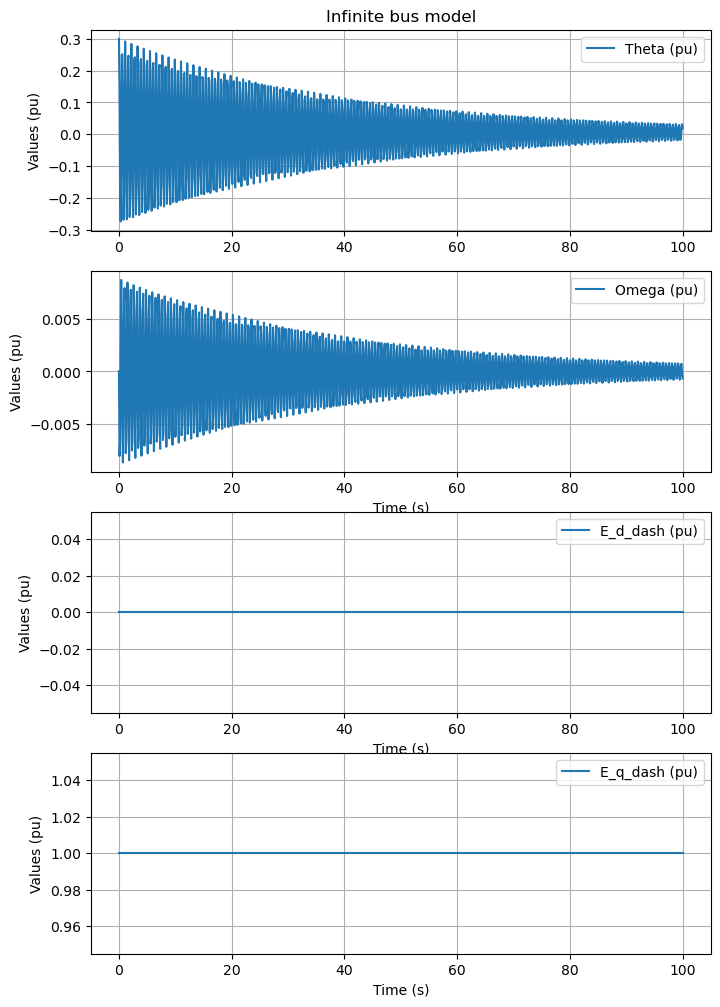

In [ ]:
#delta,omega,  E_d_dash, E_q_dash, D, P_m, theta0, omega_B , V, X_d_dash, H
plot_synchronous_machine_ib(delta0, omega0, E_d_dash0, E_q_dash0, D0, P_m0, theta_vs0, omega_B0, Vs0, X_d_dash0, H0)

Solve 2 axis model with AVR

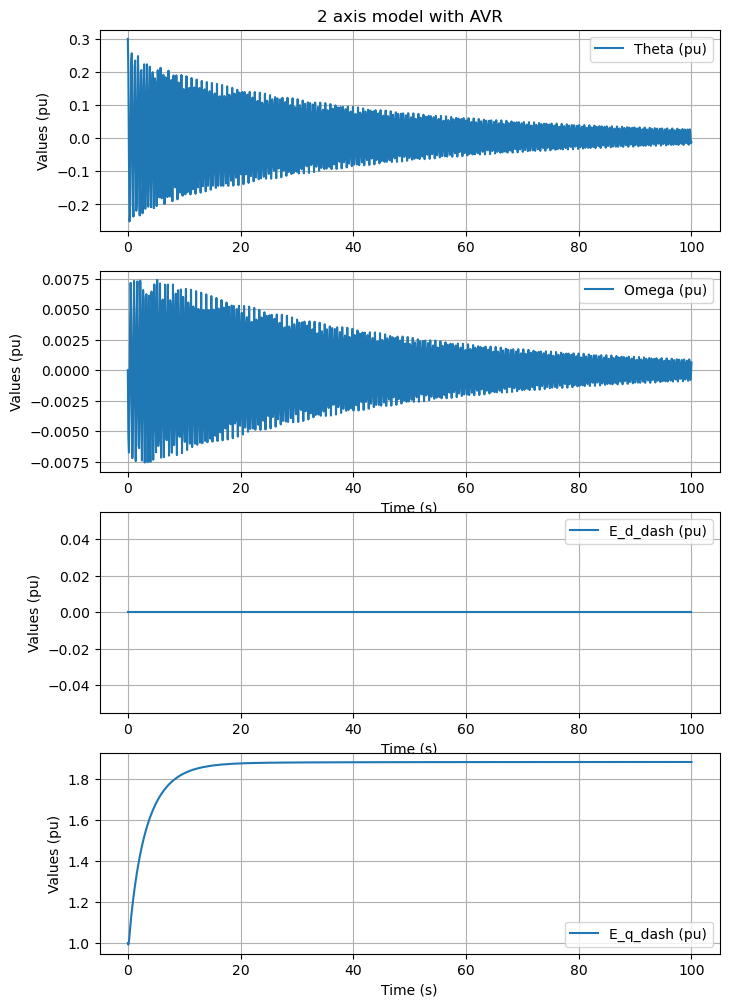

In [ ]:

solution=plot_synchronous_machine_AVR(delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, omega_B0, theta_vs0, Vs0, T_d_dash0, T_q_dash0, X_d0, X_d_dash0, X_q0, X_q_dash0, H0, D0,Rs0, K_A0, T_E0, T_F0, T_A0, K_F0, V_ref0)


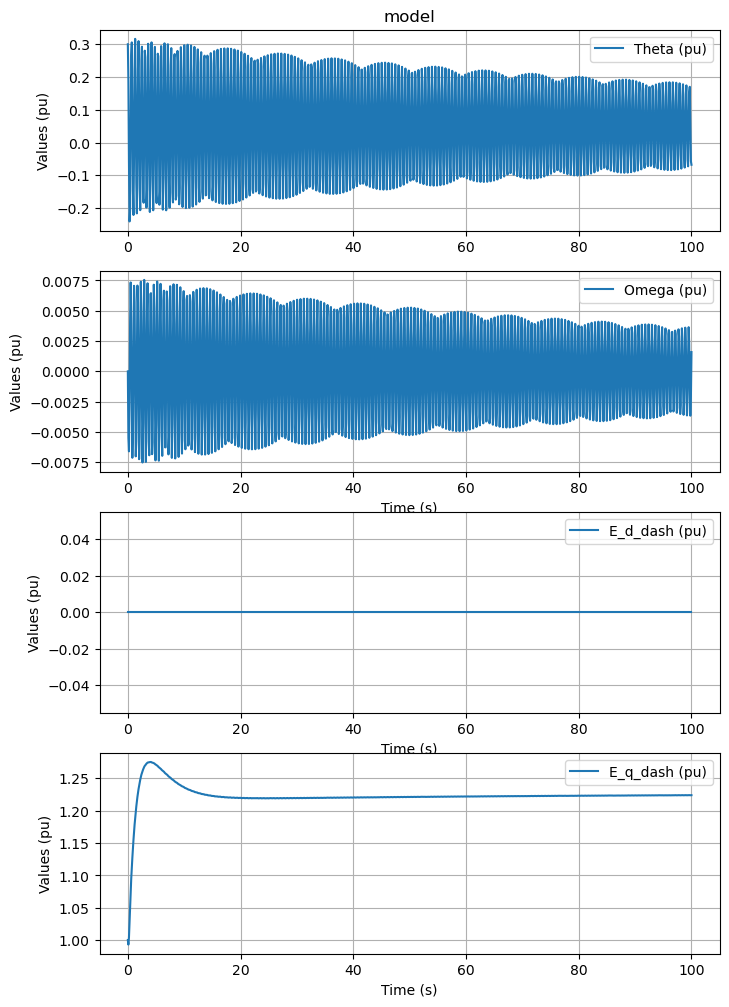

In [ ]:
P_m0 = 0.1

solution=plot_synchronous_machine_AVR_GOV(delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0, X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0, P_c0, R_d0, T_ch0, T_sv0)


In [ ]:
from models.odes.power_dynamics.sm_test0_dyn import synchronous_machine_d0

def plot_dyn_synchronous_machineAVR(delta, omega, E_d_dash, E_q_dash, E_fd, P_m,  omega_B, theta_vs, V, T_d_dash, T_q_dash, X_d, X_d_dash, X_q, X_q_dash, H, D,Rs, T_f, K_f, e_f, T_a, K_a, V_ref, T_e, K_e, T_sv, R_d, P_sv,u):
    t_span, t_eval = set_time(1000)
    r_f = 0
    v_r = 1
    # Initial state
    y0 = [delta, omega, E_d_dash, E_q_dash, r_f, v_r, E_fd, P_sv, P_m, u]                   
    solution = solve_ivp(synchronous_machine_d0, t_span, y0, args=(P_m, omega_B, theta_vs, V, T_d_dash, T_q_dash, X_d, X_d_dash, X_q, X_q_dash, H, D, Rs, T_f, K_f, e_f, T_a, K_a, V_ref, T_e, K_e, T_sv, R_d, P_sv), t_eval=t_eval)
    plotting_solution_gridspec(solution)
    return
